## 1. Data Preparation and Introduction

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, classification_report



In [17]:
df = pd.read_csv('data.csv')
print(df.head())

   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies        Contract Pape

In [14]:
print("Original shape:", df.shape)
print("Columns:", df.columns.tolist())
print("\n--- Dataset Info ---")
print(df.info())
num_cols = df.select_dtypes(include=["int64","float64"]).columns.tolist()
display(df[num_cols].describe().T)


Original shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

--- Dataset Info ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   ob

,count,mean,std,min,25%,50%,75%,max
SeniorCitizen,7043.0,0.162147,0.368612,0.00,0.0,0.00,0.00,1.00
tenure,7043.0,32.371149,24.559481,0.00,9.0,29.00,55.00,72.00
MonthlyCharges,7043.0,64.761692,30.090047,18.25,35.5,70.35,89.85,118.75


In [7]:
df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# Convert TotalCharges → numeric
df["TotalCharges"] = pd.to_numeric(df["TotalCharges"], errors="coerce")
print("Missing TotalCharges:", df["TotalCharges"].isna().sum())


Missing TotalCharges: 11


/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_8332/1731231263.py:1: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: x.strip() if isinstance(x, str) else x)


In [8]:
df["TotalCharges"] = df["TotalCharges"].fillna(0)

# Drop customerID
df.drop(columns=["customerID"], inplace=True)

# Remove duplicates
df.drop_duplicates(inplace=True)
print("Shape after duplicate removal:", df.shape)

# Handle missing values (report)
print("\nMissing values per column:")
print(df.isna().sum()[df.isna().sum()>0])

Shape after duplicate removal: (7021, 20)

Missing values per column:
Series([], dtype: int64)


In [9]:
target = "Churn"
df[target] = df[target].map({"Yes":1, "No":0})
predictors = [col for col in df.columns if col != target]

print(f"\nTarget variable: {target}")
print(f"Number of predictors: {len(predictors)}")


Target variable: Churn
Number of predictors: 19


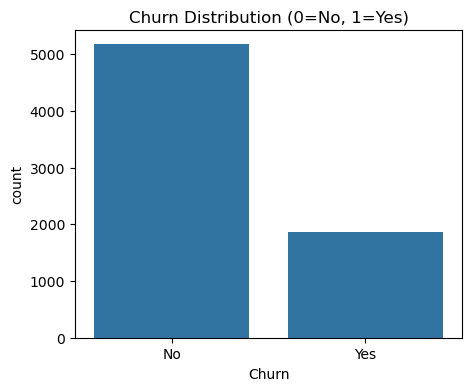

In [11]:
plt.figure(figsize=(5,4))
sns.countplot(x="Churn", data=df)
plt.title("Churn Distribution (0=No, 1=Yes)")
plt.show()

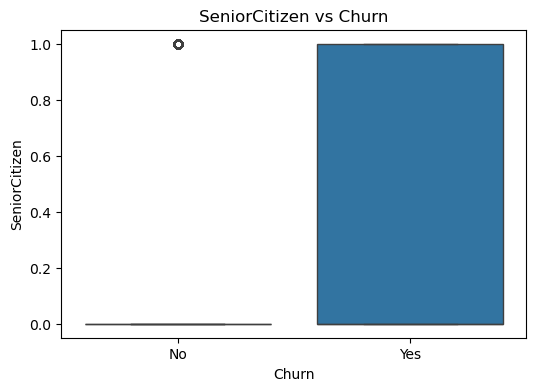

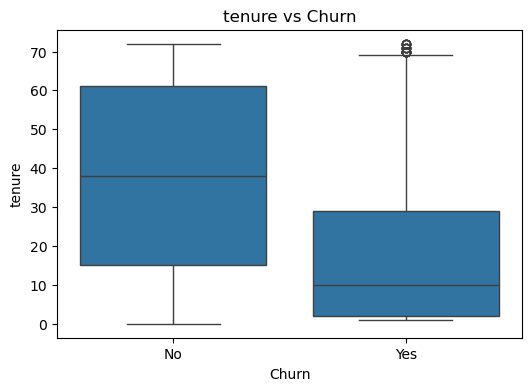

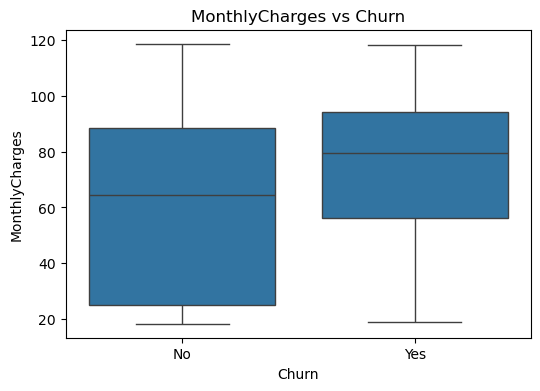

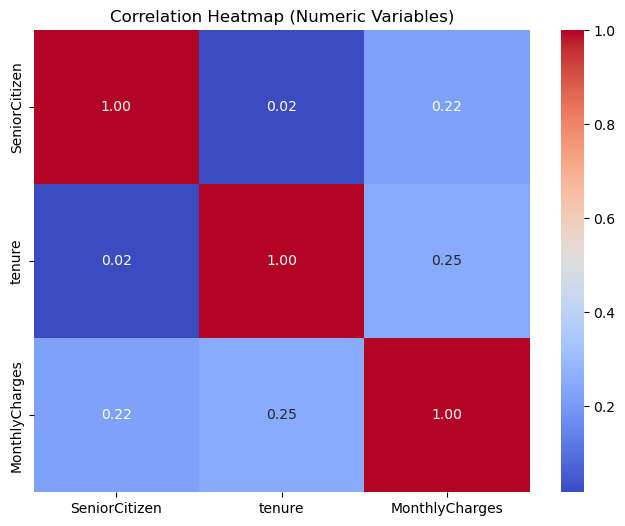

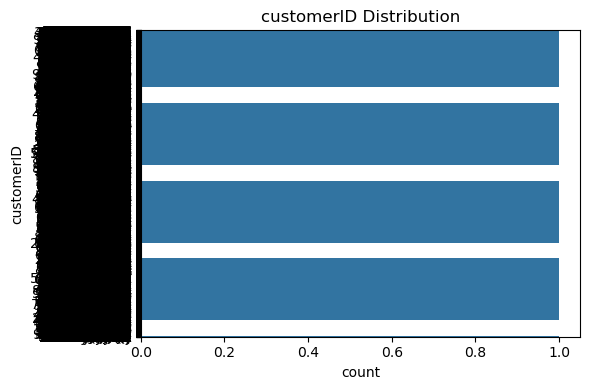

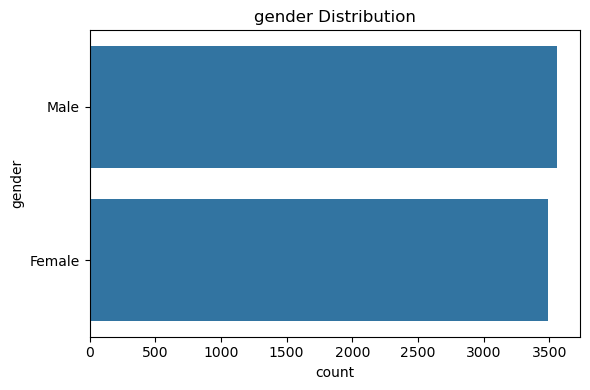

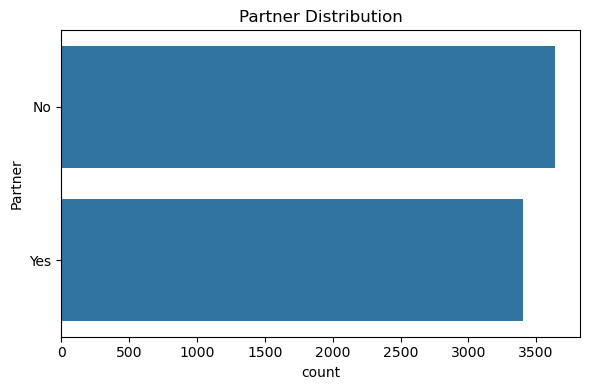

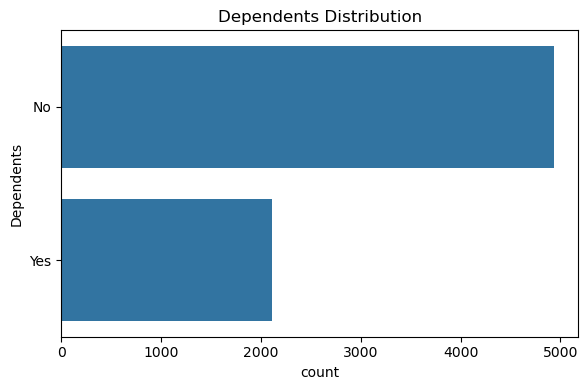

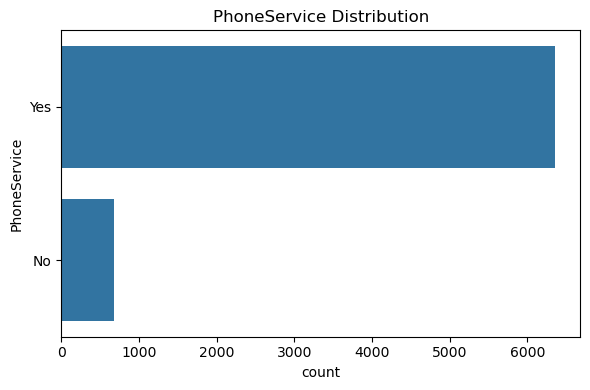

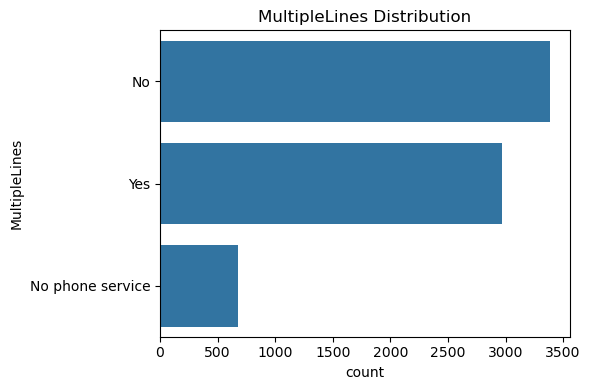

In [15]:
for col in num_cols:
    if col == "Churn": continue
    plt.figure(figsize=(6,4))
    sns.boxplot(x="Churn", y=col, data=df)
    plt.title(f"{col} vs Churn")
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df[num_cols].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Heatmap (Numeric Variables)")
plt.show()

# Countplots for top categorical columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
for col in cat_cols[:6]:  # limit to first few for readability
    plt.figure(figsize=(6,4))
    sns.countplot(y=col, data=df, order=df[col].value_counts().index)
    plt.title(f"{col} Distribution")
    plt.tight_layout()
    plt.show()

In [32]:
df_cleaned = df.copy()

# 1️⃣ Drop non-predictive or identifier columns
df_cleaned.drop(columns=['customerID'], errors='ignore', inplace=True)

# 2️⃣ Convert target column to numeric (0=No, 1=Yes)
if df_cleaned['Churn'].dtype == 'object':
    df_cleaned['Churn'] = df_cleaned['Churn'].map({'Yes': 1, 'No': 0})

# 3️⃣ Convert TotalCharges to numeric
df_cleaned['TotalCharges'] = pd.to_numeric(df_cleaned['TotalCharges'], errors='coerce')
df_cleaned['TotalCharges'] = df_cleaned['TotalCharges'].fillna(0)

# 4️⃣ Remove duplicates
df_cleaned.drop_duplicates(inplace=True)

# 5️⃣ Strip whitespace in all string columns
df_cleaned = df_cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)

# 6️⃣ Verify no missing values
print("\nMissing values after cleaning:")
print(df_cleaned.isna().sum()[df_cleaned.isna().sum() > 0])

# 7️⃣ Save cleaned dataset
os.makedirs("churn_outputs", exist_ok=True)
cleaned_path = "churn_outputs/cleaned_telco_churn.csv"
df_cleaned.to_csv(cleaned_path, index=False)

print(f"\n✅ Cleaned dataset saved successfully at: {cleaned_path}")
print("Final shape:", df_cleaned.shape)


Missing values after cleaning:
Series([], dtype: int64)

✅ Cleaned dataset saved successfully at: churn_outputs/cleaned_telco_churn.csv
Final shape: (7021, 20)


/var/folders/3w/wfm3gqnj2pj95kb0_6m_klmc0000gn/T/ipykernel_8332/3410208051.py:18: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df_cleaned = df_cleaned.applymap(lambda x: x.strip() if isinstance(x, str) else x)


## 2. Model Development and Rule Induction using CHAID

In [21]:
X = df.drop(columns=['Churn'])
y = df['Churn']

# Convert categorical columns to numeric (LabelEncoding for tree algorithms)
X_encoded = X.copy()
for col in X_encoded.select_dtypes(include=['object']).columns:
    X_encoded[col] = LabelEncoder().fit_transform(X_encoded[col])

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X_encoded, y, test_size=0.3, random_state=42, stratify=y
)
try:
    from CHAID import Tree
    print("Using real CHAID model...")
    # Example CHAID usage (if CHAID is installed)
    chaid_tree = Tree.from_pandas_df(df, dict((col, 'nominal') for col in X.columns), target='Churn')
    chaid_tree.print_tree()
except Exception as e:
    print("CHAID library not available → using DecisionTree fallback.")
    print("Error:", e)
    dt = DecisionTreeClassifier(
        criterion='entropy',    # uses information gain (similar to CHAID's chi-square)
        max_depth=5,
        min_samples_leaf=50,
        random_state=42
    )
    dt.fit(X_train, y_train)

    y_pred = dt.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"Decision Tree (CHAID-style) Accuracy: {acc:.3f}")

    # --- Extract rules ---
    tree_rules = export_text(dt, feature_names=list(X_encoded.columns))
    print("\n=== Extracted Decision Rules (CHAID-style) ===")
    print(tree_rules)
    if 'dt' in locals():
        importances = pd.DataFrame({
        'Feature': X_encoded.columns,
        'Importance': dt.feature_importances_
    }).sort_values(by='Importance', ascending=False)
    print("\n=== Top Predictors Influencing Churn ===")
    display(importances.head(10))

CHAID library not available → using DecisionTree fallback.
Error: No module named 'CHAID'
Decision Tree (CHAID-style) Accuracy: 0.786

=== Extracted Decision Rules (CHAID-style) ===
|--- Contract <= 0.50
|   |--- OnlineSecurity <= 0.50
|   |   |--- tenure <= 10.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- tenure <= 2.50
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- tenure >  2.50
|   |   |   |   |   |--- class: No
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- MultipleLines <= 1.00
|   |   |   |   |   |--- class: Yes
|   |   |   |   |--- MultipleLines >  1.00
|   |   |   |   |   |--- class: Yes
|   |   |--- tenure >  10.50
|   |   |   |--- InternetService <= 0.50
|   |   |   |   |--- MonthlyCharges <= 60.12
|   |   |   |   |   |--- class: No
|   |   |   |   |--- MonthlyCharges >  60.12
|   |   |   |   |   |--- class: No
|   |   |   |--- InternetService >  0.50
|   |   |   |   |--- PaymentMethod <= 1.50
|   |   |   |   |   |--- class: No
|  

,Feature,Importance
15,Contract,0.548069
9,OnlineSecurity,0.130032
5,tenure,0.122885
18,MonthlyCharges,0.084640
8,InternetService,0.067840
0,customerID,0.017531
17,PaymentMethod,0.010532
7,MultipleLines,0.010347
4,Dependents,0.003497
16,PaperlessBilling,0.002904


## 3. Model Comparison and Evaluation 


=== Model Performance Summary ===
Logistic Regression Accuracy: 0.800, AUC: 0.840
Decision Tree (CHAID-style) Accuracy: 0.786, AUC: 0.824


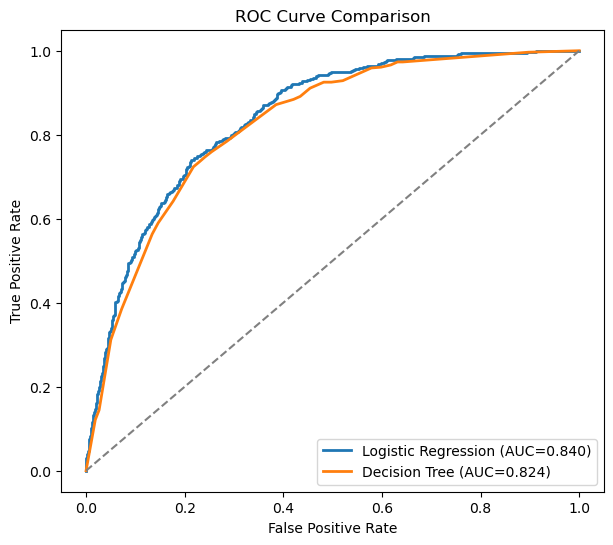

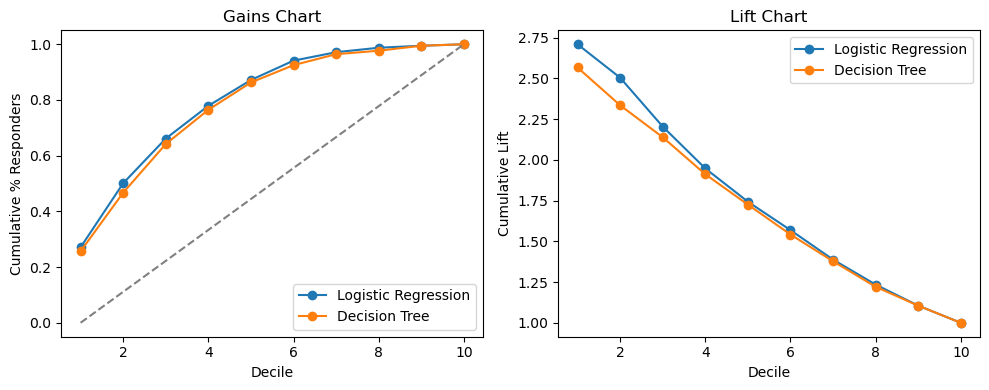


5-Fold CV Accuracy (Logistic): 0.798
5-Fold CV Accuracy (Tree): 0.793


In [25]:
logreg = LogisticRegression(max_iter=1000, solver='liblinear')
logreg.fit(X_train, y_train)
y_pred_log = logreg.predict(X_test)
y_prob_log = logreg.predict_proba(X_test)[:, 1]
y_pred_tree = dt.predict(X_test)
y_prob_tree = dt.predict_proba(X_test)[:, 1]

# --- Accuracy comparison ---
from sklearn.metrics import accuracy_score

acc_log = accuracy_score(y_test, y_pred_log)
acc_tree = accuracy_score(y_test, y_pred_tree)
auc_log = roc_auc_score(y_test, y_prob_log)
auc_tree = roc_auc_score(y_test, y_prob_tree)

print("\n=== Model Performance Summary ===")
print(f"Logistic Regression Accuracy: {acc_log:.3f}, AUC: {auc_log:.3f}")
print(f"Decision Tree (CHAID-style) Accuracy: {acc_tree:.3f}, AUC: {auc_tree:.3f}")

# Ensure target labels are numeric (0/1)
y_train = y_train.map({'No': 0, 'Yes': 1}) if y_train.dtype == 'object' else y_train
y_test = y_test.map({'No': 0, 'Yes': 1}) if y_test.dtype == 'object' else y_test


# --- ROC Curve comparison ---
fpr_log, tpr_log, _ = roc_curve(y_test, y_prob_log)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

plt.figure(figsize=(7,6))
plt.plot(fpr_log, tpr_log, label=f"Logistic Regression (AUC={auc_log:.3f})", lw=2)
plt.plot(fpr_tree, tpr_tree, label=f"Decision Tree (AUC={auc_tree:.3f})", lw=2)
plt.plot([0,1],[0,1], '--', color='gray')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc='lower right')
plt.show()

# --- Lift & Gains Chart ---
def gains_lift_table(y_true, y_score, groups=10):
    data = pd.DataFrame({'y': y_true, 'score': y_score})
    data = data.sort_values('score', ascending=False).reset_index(drop=True)
    data['decile'] = pd.qcut(data.index, groups, labels=False)
    grouped = data.groupby('decile')
    summary = grouped['y'].agg(['count', 'sum']).rename(columns={'count':'n','sum':'responders'})
    summary['response_rate'] = summary['responders']/summary['n']
    summary['cum_responders'] = summary['responders'].cumsum()
    summary['cum_response_rate'] = summary['cum_responders']/summary['responders'].sum()
    summary['lift'] = summary['response_rate']/ (data['y'].mean())
    summary['cum_lift'] = summary['cum_response_rate'] / ((summary.index+1)/groups)
    return summary

gains_log = gains_lift_table(y_test, y_prob_log)
gains_tree = gains_lift_table(y_test, y_prob_tree)

plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(gains_log.index+1, gains_log['cum_response_rate'], label='Logistic Regression', marker='o')
plt.plot(gains_tree.index+1, gains_tree['cum_response_rate'], label='Decision Tree', marker='o')
plt.plot([1,10],[0,1],'--',color='gray')
plt.title("Gains Chart")
plt.xlabel("Decile")
plt.ylabel("Cumulative % Responders")
plt.legend()

plt.subplot(1,2,2)
plt.plot(gains_log.index+1, gains_log['cum_lift'], label='Logistic Regression', marker='o')
plt.plot(gains_tree.index+1, gains_tree['cum_lift'], label='Decision Tree', marker='o')
plt.title("Lift Chart")
plt.xlabel("Decile")
plt.ylabel("Cumulative Lift")
plt.legend()
plt.tight_layout()
plt.show()

# --- Validation: 5-Fold Cross-Validation Accuracy ---
from sklearn.model_selection import cross_val_score
cv_log = cross_val_score(logreg, X_encoded, y, cv=5, scoring='accuracy').mean()
cv_tree = cross_val_score(dt, X_encoded, y, cv=5, scoring='accuracy').mean()

print(f"\n5-Fold CV Accuracy (Logistic): {cv_log:.3f}")
print(f"5-Fold CV Accuracy (Tree): {cv_tree:.3f}")


## 4. Model Deployment and Updating

In [30]:
joblib.dump(logreg, "logistic_churn_model.pkl")
joblib.dump(dt, "decision_tree_churn_model.pkl")
print("✅ Models saved successfully.")


loaded_model = joblib.load("logistic_churn_model.pkl")


✅ Models saved successfully.


In [31]:

# Prepare the new customer data (same columns as training)
new_customer = pd.DataFrame({
    'gender': ['Female'],
    'SeniorCitizen': [0],
    'Partner': ['Yes'],
    'Dependents': ['No'],
    'tenure': [5],
    'PhoneService': ['Yes'],
    'MultipleLines': ['No'],
    'InternetService': ['Fiber optic'],
    'OnlineSecurity': ['No'],
    'OnlineBackup': ['No'],
    'DeviceProtection': ['No'],
    'TechSupport': ['No'],
    'StreamingTV': ['Yes'],
    'StreamingMovies': ['No'],
    'Contract': ['Month-to-month'],
    'PaperlessBilling': ['Yes'],
    'PaymentMethod': ['Electronic check'],
    'MonthlyCharges': [80.5],
    'TotalCharges': [402.5]
})

# Encode categorical columns the same way as during training
new_customer_encoded = new_customer.copy()

for col in new_customer_encoded.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    le.fit(df[col])  # fit encoder on the same categories as training data
    new_customer_encoded[col] = le.transform(new_customer_encoded[col])

# Ensure same columns and order as training data
missing_cols = set(X_encoded.columns) - set(new_customer_encoded.columns)
for col in missing_cols:
    new_customer_encoded[col] = 0

new_customer_encoded = new_customer_encoded[X_encoded.columns]

# Predict churn probability
prob = loaded_model.predict_proba(new_customer_encoded)[0][1]
print(f"Predicted churn probability: {prob:.2f}")

Predicted churn probability: 0.71
